In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np

from mrcs_loader import get_all_imgs_from_paths, get_files_of_type_from_path, load_paths_into_array
from Featurizer import Featurizer, FeatureEnsembler
import ImageTransforms
from GBDT import GBDTWrapper


# Create Dataset

In [2]:
# Data path
data_path = '../../data/Extract/'

# Paths of good/bad .mrcs files
good_path_in = os.path.join(data_path, 'job028/micrographs')
bad_path_in = os.path.join(data_path, 'job031/micrographs')

data_file_ext = '_lowpass.mrcs'

data_paths = {'good':get_files_of_type_from_path(good_path_in, data_file_ext),  
              'bad':get_files_of_type_from_path(bad_path_in, data_file_ext)}

data = {'good': get_all_imgs_from_paths(data_paths['good']),
        'bad': get_all_imgs_from_paths(data_paths['bad'])}


# Transform syntax

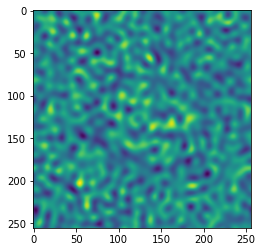

In [3]:
plt.imshow(data['good'][0])
plt.show()

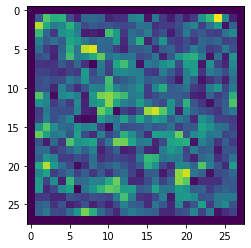

In [4]:
T_Roberts = ImageTransforms.RobertsTransform()
plt.imshow(T_Roberts.transform(data['good'][0]))
plt.show()

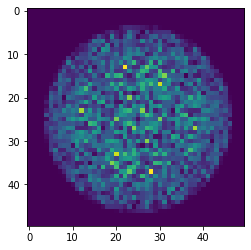

In [5]:
T_FFT2 = ImageTransforms.FFT2Transform()
plt.imshow(T_FFT2.transform(data['good'][0]))
plt.show()

# Training a model using features from images only

In [6]:
data_all = data['good']+data['bad']
target = np.concatenate([np.ones(len(data['good'])), np.zeros(len(data['bad']))], axis=0)

Preprocessing data . . .
Fitting estimators . . .
Calculating 6 features using PCA...
	Time taken = 1.402s
Calculating 6 features using FastICA...
	Time taken = 6.233s
Calculating 6 features using FactorAnalysis...
	Time taken = 3.506s
Calculating features . . .
Done!
Training GBDT . . .
Done!


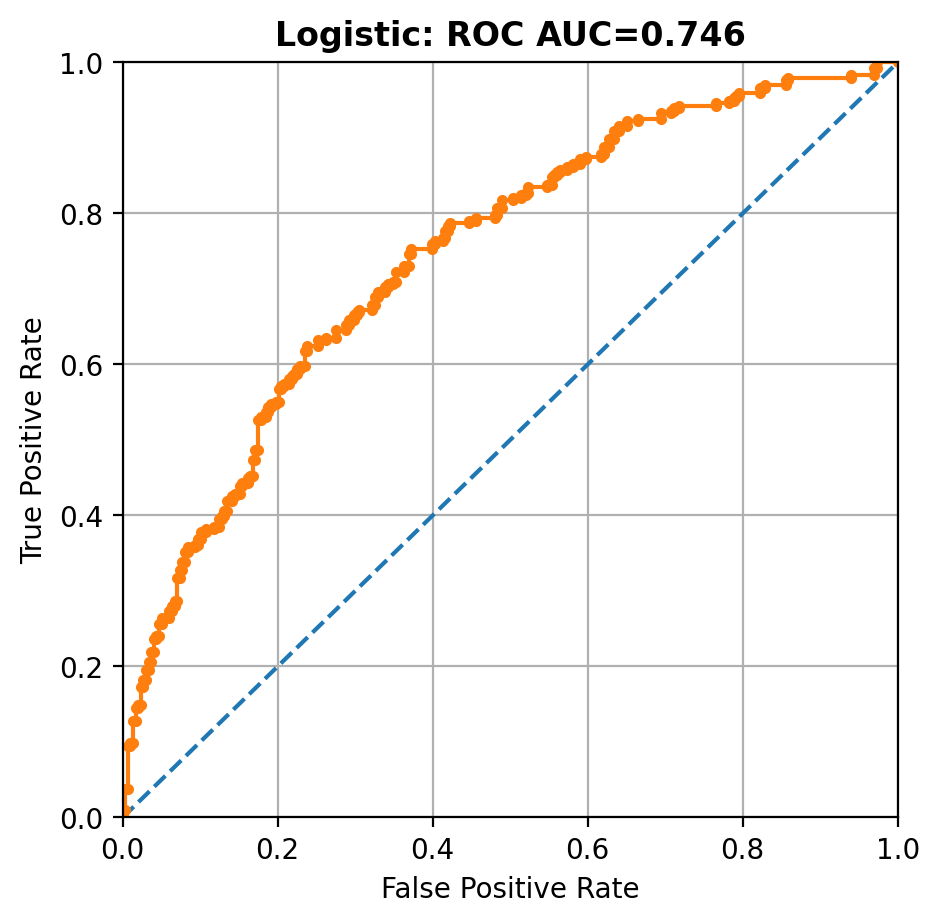

In [7]:
# Get features
F = Featurizer(data_all, n_components=6)
F.fit()

# Build model
LGB_params = params={
            "objective" : "binary",
            "metric" : "auc",
            "boosting": 'gbdt',
            "max_depth" : -1,
            "learning_rate" : 0.01,
            "verbosity" : 1,
            "seed": 0
            }
G = GBDTWrapper(F.feature_coeffs, target, params=LGB_params)
G.train()
G.plotROC()

# Training a model using features from multiple image transforms

Applying transform: Identity
Preprocessing data . . .
Fitting estimators . . .
Calculating 21 features using PCA...
	Time taken = 1.489s
Calculating 21 features using FastICA...
	Time taken = 6.339s
Calculating 21 features using FactorAnalysis...
	Time taken = 6.575s
Calculating features . . .
Done!
Applying transform: Roberts
Preprocessing data . . .
Fitting estimators . . .
Calculating 21 features using PCA...
	Time taken = 0.010s
Calculating 21 features using FastICA...
	Time taken = 0.158s
Calculating 21 features using FactorAnalysis...
	Time taken = 0.104s
Calculating features . . .
Done!
Applying transform: FFT2
Preprocessing data . . .
Fitting estimators . . .
Calculating 21 features using PCA...
	Time taken = 0.037s
Calculating 21 features using FastICA...
	Time taken = 0.704s
Calculating 21 features using FactorAnalysis...
	Time taken = 0.139s
Calculating features . . .
Done!
Training GBDT . . .
Done!


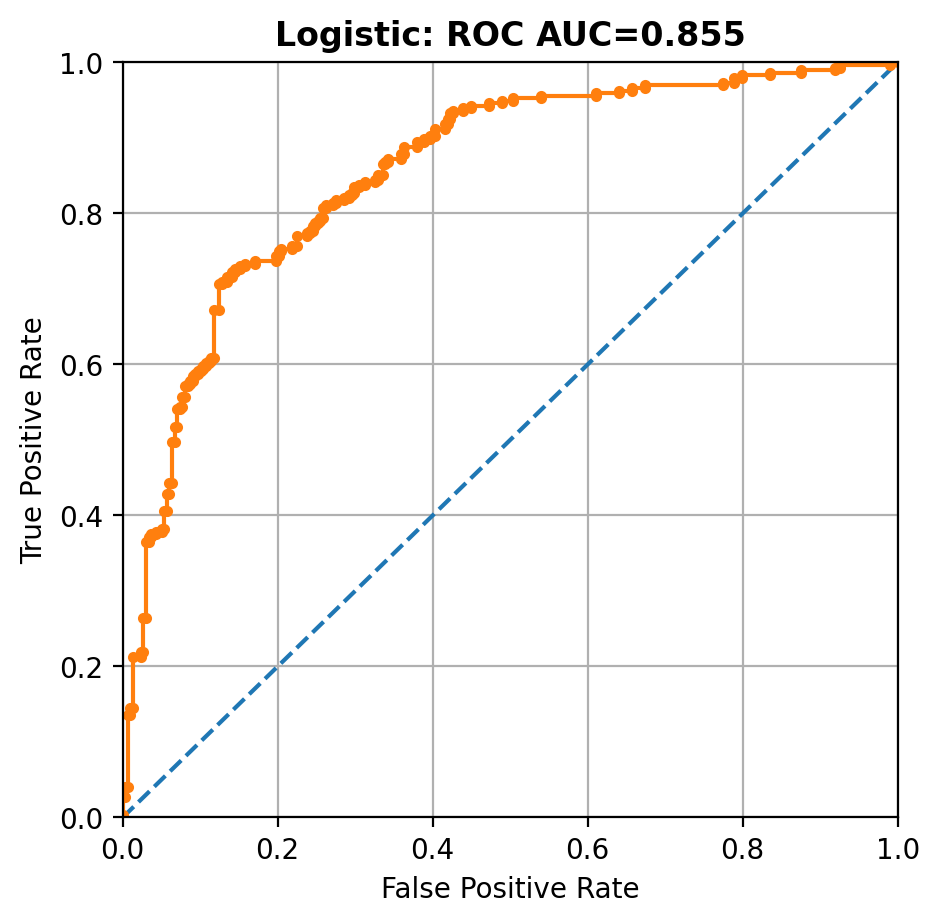

In [9]:
# List of transforms to apply, we include the identity transform
transforms = [ImageTransforms.IdentityTransform(), ImageTransforms.RobertsTransform(), ImageTransforms.FFT2Transform()]
ensembler = FeatureEnsembler(data_all, transforms, n_components=21)
ensembler.fit()

# Build model
G = GBDTWrapper(ensembler.feature_coeffs, target)
G.train()
G.plotROC()